In [ ]:
!pip install torchviz 
!pip intasll pytorch-model-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "intasll" - maybe you meant "install"


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys 
import cv2 
import sklearn
import shutil 
import glob 
import time 

import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 

import torchvision 
import torchvision.transforms as transforms 
import torchvision.models as models


from torchviz import make_dot 
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader 
from sklearn.model_selection import train_test_split 
from google.colab import drive

#### Transfer learning 

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FILE_PATH = "/content/drive/MyDrive/dataset/pytorch/catanddog.zip"
EXTRACTOR_PATH = "/content/dataset/"
!unzip "/content/drive/MyDrive/dataset/pytorch/catanddog.zip" -d "/content/dataset/"

In [ ]:
data_path = "/content/dataset/train/"

transform = transforms.Compose([
                                transforms.Resize([256, 256]),
                                transforms.RandomResizedCrop(224), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor(), 
])

train_dataset = torchvision.datasets.ImageFolder(data_path, 
                                                 transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=8, 
                                           shuffle = True)

print(len(train_dataset))

385


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


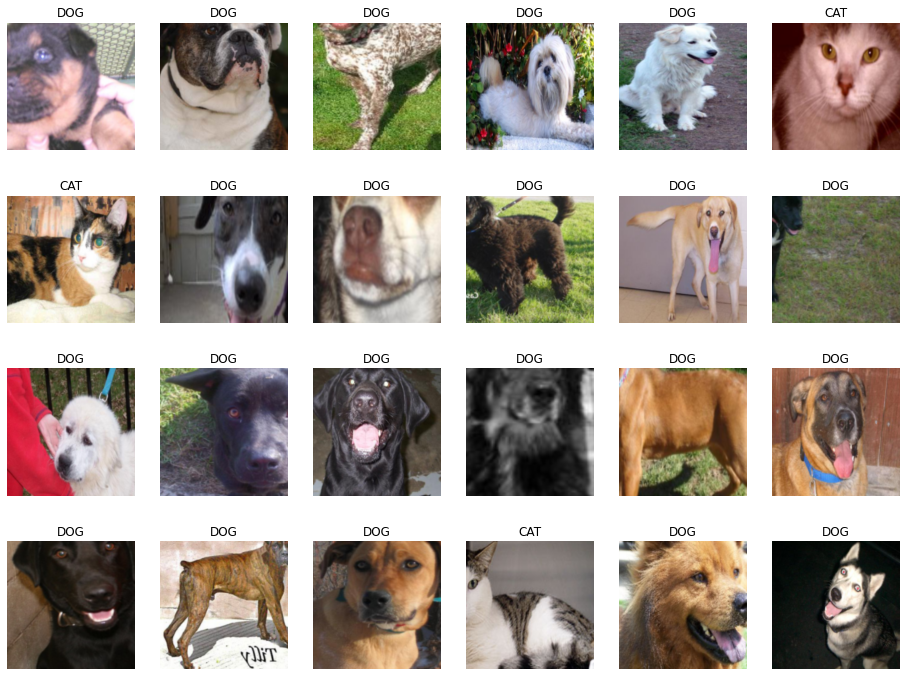

In [ ]:
samples, labels  = iter(train_loader).next()
classes = {0: "CAT", 1:"DOG"} 
fig = plt.figure(figsize=(16, 24))
for i in range(24): 
    axes = fig.add_subplot(4, 6, i+1)
    axes.set_title(classes[labels[i].item()])
    axes.axis("off")
    axes.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
def set_parameter_require_grad(model, feature_extracting=True):
    if feature_extracting : 
        for param in model.parameters(): 
            param.requires_grad = False 

In [ ]:
set_parameter_require_grad(resnet)

In [ ]:
resnet.fc = nn.Linear(512, 2)

In [ ]:
for name, param in resnet.named_parameters(): 
    if param.requires_grad: 
        print(name,  param.data)

fc.weight tensor([[ 9.6982e-03, -2.5363e-02,  3.3190e-02,  ..., -1.2677e-02,
          2.4549e-02,  1.6711e-02],
        [-1.9324e-02,  2.4414e-02, -4.8580e-05,  ..., -4.1700e-02,
         -9.0611e-03, -2.2619e-02]])
fc.bias tensor([-0.0302,  0.0431])


In [ ]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False 
model.fc = torch.nn.Linear(512, 2)

for param in model.fc.parameters(): 
    param.requires_grad = True 

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('/content/dataset/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [ ]:
params_to_update = []
for name,param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 0.3639 Acc: 0.8519

Epoch 1/12
----------
Loss: 0.2975 Acc: 0.8987

Epoch 2/12
----------
Loss: 0.2964 Acc: 0.8883

Epoch 3/12
----------
Loss: 0.3362 Acc: 0.8727

Epoch 4/12
----------
Loss: 0.2192 Acc: 0.9325

Epoch 5/12
----------
Loss: 0.2553 Acc: 0.8857

Epoch 6/12
----------
Loss: 0.2387 Acc: 0.9013

Epoch 7/12
----------
Loss: 0.2092 Acc: 0.9195

Epoch 8/12
----------
Loss: 0.2327 Acc: 0.9065

Epoch 9/12
----------
Loss: 0.2323 Acc: 0.9091

Epoch 10/12
----------
Loss: 0.2235 Acc: 0.8987

Epoch 11/12
----------
Loss: 0.1884 Acc: 0.9195

Epoch 12/12
----------
Loss: 0.2127 Acc: 0.9247

Training complete in 7m 55s
Best Acc: 0.932468


In [ ]:
test_path = "/contet/dataset/validataion"

transform = trainsforms.Compose([
                                 transforms.Resize(224),
                                 transforms.CenterCrop(224), 
                                 transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path, 
    transform
)

test_loader = torch.utils.data.DataLoader()